# Setup

In [ ]:
# give colab permission to access drive (I had to give it all permissions before this would work...)
from google.colab import drive
drive.mount('/content/drive')

repo_path = '/content/drive/MyDrive/odeformer' # folder where odeformer is stored
script_path = '/content/drive/MyDrive/aisc' # folder containing the script generate_samples.py
samples_path = '/content/drive/MyDrive/aisc/samples' # where you want to save samples
activations_path = '/content/drive/MyDrive/aisc/activations' # where you want to save activations
%cd {script_path}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/aisc


In [ ]:
# clone odeformer into google drive (if needed)
# !git clone https://github.com/sdascoli/odeformer.git {aisc_folder}

In [ ]:
!pip install --quiet numexpr sympy==1.11.1 matplotlib numpy pandas requests scikit-learn scipy seaborn setproctitle torch tqdm wandb gdown regex

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9

In [ ]:
import sys
import uuid
import json
import os
import numpy as np
import torch
import re

try:
    from odeformer.envs.environment import FunctionEnvironment
    # from odeformer.envs.generators import NodeList # Why is this here? --> Was for json saving
    from parsers import get_parser
except ModuleNotFoundError as e:
    print("[ERROR] Could not import odeformer. Check path and installation.")
    raise e

In [ ]:
# get params as arg for creating the function environment
# need to check the default params set in get_parser()
parser = get_parser()
params = parser.parse_args(args=[])
# create function environment, which is able to generate samples
env = FunctionEnvironment(params)

# Sample generation

In [ ]:
def identify_operators(sample):
    operators_real = {
      "add": 2, "sub": 2, "mul": 2, "div": 2, "abs": 1, "inv": 1, "sqrt": 1,
      "log": 1, "exp": 1, "sin": 1, "arcsin": 1, "cos": 1, "arccos": 1,
      "tan": 1, "arctan": 1, "pow2": 1, "pow3": 1, 'id': 1
    }
    operators_extra = {"pow": 2}
    all_operators = {**operators_real, **operators_extra}

    skeleton_tree_encoded = sample['skeleton_tree_encoded']
    operator_dict = {operator: 1 if operator in skeleton_tree_encoded else 0 for operator in all_operators}
    sample['operator_dict'] = operator_dict
    return sample

In [ ]:
def identify_features(sample):

    def identify_multiple_features(feature_operators, feature_name, operator_dict):
        if any(operator_dict.get(operator, 0) == 1 for operator in feature_operators):
            feature_dict[feature_name] = 1
        else:
            feature_dict[feature_name] = 0

    trig_funs = ['sin', 'cos', 'tan']
    inv_trig_funs = ['arcsin', 'arccos', 'arctan']
    features_single = ['pow2', 'pow3', 'log', 'sqrt', 'exp']


    operator_dict = sample['operator_dict']
    feature_dict = {}

    for feature in features_single:
      feature_dict[feature] = operator_dict[feature]

    identify_multiple_features(trig_funs, 'trig', operator_dict)
    identify_multiple_features(inv_trig_funs, 'inv_trig', operator_dict)

    sample['feature_dict'] = feature_dict
    return sample

**Information about samples**

Each sample is a dictionary with entries:
1. times,
2. trajectory,
3. tree_encoded: prefix notation, as list of operators and exact constants
4. skeleton_tree_encoded: same as above, but with 'CONSTANT' instead of constants' values
5. tree
6. skeleton_tree: same as (4) but normal maths expression rather than prefix notation
7. infos: number of points, number of unary and binary operators, dimension

The following is adapted from Helen's notebook / file on sample generation; https://github.com/ayoakin/MIVLDE/blob/LLMProbing/subteams/LLMProbing/sample_generation/generate_samples.py

In [72]:
os.makedirs(samples_path, exist_ok=True)
seed = 42 # Set seed for deterministic sample generation (for now)
# seed = None # Random seed (turn on if wanted)
seed_gen = np.random.RandomState(seed)

In [83]:
n_samples = 10

for i in range(n_samples):
  sample_seed = seed_gen.randint(1_000_000_000)
  # Number copied somewhere from their github (https://github.com/sdascoli/odeformer/blob/c9193012ad07a97186290b98d8290d1a177f4609/odeformer/trainer.py#L244)
  # May need to set with more care?
  env.rng = np.random.RandomState(sample_seed)
  sample, errors = env.gen_expr(train=True)
  sample = identify_operators(sample)
  sample = identify_features(sample)

  # Generate filename
  sample_filename = f"sample_{sample_seed}.pt"
  sample_filepath = os.path.join(samples_path, sample_filename)

  # Save file using torch with pickle
  torch.save(sample, sample_filepath)
  print(f"[INFO] Saved to {sample_filepath}")

print("[INFO] Data generation complete.")

[INFO] Saved to /content/drive/MyDrive/aisc/samples/sample_669991378.pt
[INFO] Saved to /content/drive/MyDrive/aisc/samples/sample_429389014.pt
[INFO] Saved to /content/drive/MyDrive/aisc/samples/sample_249467210.pt
[INFO] Saved to /content/drive/MyDrive/aisc/samples/sample_898717130.pt
[INFO] Saved to /content/drive/MyDrive/aisc/samples/sample_498972759.pt
[INFO] Saved to /content/drive/MyDrive/aisc/samples/sample_359525748.pt
[INFO] Saved to /content/drive/MyDrive/aisc/samples/sample_434285667.pt
[INFO] Saved to /content/drive/MyDrive/aisc/samples/sample_613608295.pt
[INFO] Saved to /content/drive/MyDrive/aisc/samples/sample_893664919.pt
[INFO] Saved to /content/drive/MyDrive/aisc/samples/sample_648061058.pt
[INFO] Data generation complete.


# Extracting activations from generated samples

In [74]:
from odeformer.model import SymbolicTransformerRegressor
dstr = SymbolicTransformerRegressor(from_pretrained=True)
model_args = {'beam_size': 50, 'beam_temperature': 0.1}
dstr.set_model_args(model_args)

Found pretrained model at odeformer.pt
Loaded pretrained model


In [75]:
# Copied from Soumyadeep's notebook

layer_outputs = {}

# Function to store the output of each layer
def hook_fn(module, input, output, layer_name):
    layer_outputs[layer_name] = output.detach().cpu() #  detach to avoid unnecessary gradient tracking, and move to store in cpu

# Registering hooks for layers in the encoder and decoder
def register_hooks(model_part, part_name):
    for idx, module in enumerate(model_part.attentions):  # MultiHeadAttention layers
        layer_name = f"{part_name}_attention_{idx}"
        module.register_forward_hook(lambda module, input, output, name=layer_name: hook_fn(module, input, output, name))

    for idx, module in enumerate(model_part.ffns):  # FeedForward layers
        layer_name = f"{part_name}_ffn_{idx}"
        module.register_forward_hook(lambda module, input, output, name=layer_name: hook_fn(module, input, output, name))

    for idx, module in enumerate(model_part.layer_norm1):  # LayerNorm 1 layers
        layer_name = f"{part_name}_layer_norm1_{idx}"
        module.register_forward_hook(lambda module, input, output, name=layer_name: hook_fn(module, input, output, name))

    for idx, module in enumerate(model_part.layer_norm2):  # LayerNorm 2 layers
        layer_name = f"{part_name}_layer_norm2_{idx}"
        module.register_forward_hook(lambda module, input, output, name=layer_name: hook_fn(module, input, output, name))

# Registering hooks for the encoder and decoder parts
register_hooks(dstr.model.encoder, 'encoder')
register_hooks(dstr.model.decoder, 'decoder')

In [76]:
# samples_dir = os.fsencode(samples_path)

# for sample in os.listdir(samples_dir):
#     sample_name = os.fsdecode(sample)
#     # if sample_name.endswith(".pt"):
#     #     pass
#     # Assume that all files in sample are samples saved in the correct way

#     sample_path = os.path.join(samples_path, sample_name)
#     test_sample = torch.load(sample_path)
#     print(f"[INFO] Loaded sample from {sample_path}")
#     break

In [77]:
# # Passing data through the model to capture layer outputs
# with torch.no_grad():
#     dstr.fit(test_sample['times'], test_sample['trajectory'])

In [78]:
# encoder_layer_outputs = {}
# decoder_layer_outputs = {}
# activations = {}

# # Now, layer_outputs contains the outputs of the layers
# for layer_name, output in layer_outputs.items():
#     # print(f"Layer: {layer_name}, Output Shape: {output.shape}")
#     if 'ffn' in layer_name:
#     # Look at ouputs of ffn layers since they come before layer norm?
#       print(f'Layer: {layer_name}, Output Shape: {output.shape}')
#       if 'encoder' in layer_name:
#         encoder_layer_outputs[layer_name] = output
#       if 'decoder' in layer_name:
#         decoder_layer_outputs[layer_name] = output

# activations['encoder'] = encoder_layer_outputs
# activations['decoder'] = decoder_layer_outputs
# activations['operator_dict'] = test_sample['operator_dict']
# activations['feature_dict'] = test_sample['feature_dict']

In [79]:
# print(activations.keys())

In [80]:
# test_seed = re.findall(r'\d+', sample_name)[0]

# print(sample_name)
# print(test_seed)

# activation_filename = f"activation_{test_seed}.pt"
# activation_filepath = os.path.join(activations_path, activation_filename)

# torch.save(activations, activation_filepath)

In [84]:
# Turn the above into a loop over the samples directory

os.makedirs(activations_path, exist_ok=True)

samples_dir = os.fsencode(samples_path)
for sample in os.listdir(samples_dir):
  sample_name = os.fsdecode(sample)
  sample_path = os.path.join(samples_path, sample_name)
  test_sample = torch.load(sample_path)
  print(f"[INFO] Loaded sample from {sample_path}")
  with torch.no_grad():
    dstr.fit(test_sample['times'], test_sample['trajectory'])
  encoder_layer_outputs = {}
  decoder_layer_outputs = {}
  activations = {}

  for layer_name, output in layer_outputs.items():
      if 'ffn' in layer_name:
      # Look at ouputs of ffn layers since they come before layer norm?
        if 'encoder' in layer_name:
          encoder_layer_outputs[layer_name] = output
        if 'decoder' in layer_name:
          decoder_layer_outputs[layer_name] = output

  activations['encoder'] = encoder_layer_outputs
  activations['decoder'] = decoder_layer_outputs
  activations['operator_dict'] = test_sample['operator_dict']
  activations['feature_dict'] = test_sample['feature_dict']

  test_seed = re.findall(r'\d+', sample_name)[0]
  activation_filename = f"activation_{test_seed}.pt"
  activation_filepath = os.path.join(activations_path, activation_filename)
  torch.save(activations, activation_filepath)
  print(f"[INFO] Saved activations to {activation_filepath}")

[INFO] Loaded sample from /content/drive/MyDrive/aisc/samples/sample_669991378.pt
[INFO] Saved activations to /content/drive/MyDrive/aisc/activations/activation_669991378.pt
[INFO] Loaded sample from /content/drive/MyDrive/aisc/samples/sample_429389014.pt
[INFO] Saved activations to /content/drive/MyDrive/aisc/activations/activation_429389014.pt
[INFO] Loaded sample from /content/drive/MyDrive/aisc/samples/sample_249467210.pt
[INFO] Saved activations to /content/drive/MyDrive/aisc/activations/activation_249467210.pt
[INFO] Loaded sample from /content/drive/MyDrive/aisc/samples/sample_898717130.pt
[INFO] Saved activations to /content/drive/MyDrive/aisc/activations/activation_898717130.pt
[INFO] Loaded sample from /content/drive/MyDrive/aisc/samples/sample_498972759.pt
[INFO] Saved activations to /content/drive/MyDrive/aisc/activations/activation_498972759.pt
[INFO] Loaded sample from /content/drive/MyDrive/aisc/samples/sample_359525748.pt
[INFO] Saved activations to /content/drive/MyDri

In [ ]:
# print(len(encoder_layer_outputs))
# print(len(decoder_layer_outputs))
# # These appear to be +1 to how many there should be. I guess the embedding layer norm is counted?

5
13


In [ ]:
# print(dstr_encoder)

TransformerModel(
  (layer_norm_emb): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
  (attentions): ModuleList(
    (0-3): 4 x MultiHeadAttention(
      (q_lin): Linear(in_features=256, out_features=256, bias=True)
      (k_lin): Linear(in_features=256, out_features=256, bias=True)
      (v_lin): Linear(in_features=256, out_features=256, bias=True)
      (out_lin): Linear(in_features=256, out_features=256, bias=True)
    )
  )
  (layer_norm1): ModuleList(
    (0-3): 4 x LayerNorm((256,), eps=1e-12, elementwise_affine=True)
  )
  (ffns): ModuleList(
    (0-3): 4 x TransformerFFN(
      (midlin): ModuleList()
      (lin1): Linear(in_features=256, out_features=1024, bias=True)
      (lin2): Linear(in_features=1024, out_features=256, bias=True)
    )
  )
  (layer_norm2): ModuleList(
    (0-3): 4 x LayerNorm((256,), eps=1e-12, elementwise_affine=True)
  )
)


In [ ]:
# print(dstr_decoder)

TransformerModel(
  (position_embeddings): Embedding(4096, 512)
  (embeddings): Embedding(10293, 512, padding_idx=82)
  (layer_norm_emb): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
  (attentions): ModuleList(
    (0-11): 12 x MultiHeadAttention(
      (q_lin): Linear(in_features=512, out_features=512, bias=True)
      (k_lin): Linear(in_features=512, out_features=512, bias=True)
      (v_lin): Linear(in_features=512, out_features=512, bias=True)
      (out_lin): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (layer_norm1): ModuleList(
    (0-11): 12 x LayerNorm((512,), eps=1e-12, elementwise_affine=True)
  )
  (ffns): ModuleList(
    (0-11): 12 x TransformerFFN(
      (midlin): ModuleList()
      (lin1): Linear(in_features=512, out_features=2048, bias=True)
      (lin2): Linear(in_features=2048, out_features=512, bias=True)
    )
  )
  (layer_norm2): ModuleList(
    (0-11): 12 x LayerNorm((512,), eps=1e-12, elementwise_affine=True)
  )
  (layer_norm15): Mod

# Experimenting with ODEFormer

In [ ]:
from odeformer.metrics import r2_score
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

### Testing previously generated sample

In [108]:
test_sample['tree']

-0.1877 * (x_0)**3

In [110]:
test_sample['tree_encoded']

['mul', '-', 'N1877', 'E-4', 'pow', 'x_0', 'INT+', '3']

In [109]:
test_sample['operator_dict']

{'add': 0,
 'sub': 0,
 'mul': 1,
 'div': 0,
 'abs': 0,
 'inv': 0,
 'sqrt': 0,
 'log': 0,
 'exp': 0,
 'sin': 0,
 'arcsin': 0,
 'cos': 0,
 'arccos': 0,
 'tan': 0,
 'arctan': 0,
 'pow2': 0,
 'pow3': 0,
 'id': 0,
 'pow': 1}

In [61]:
# test_sample = samples[-1]
# test_sample = sample
times = test_sample['times']
trajectory = test_sample['trajectory']

candidates = dstr.fit(times, trajectory)
dstr.print(n_predictions=1)
pred_trajectory = dstr.predict(times, trajectory[0])

x_0' = -0.0636 * (0.0505 + -0.0891 * x_0)**-1 + -0.2868 * x_0


In [62]:
ground_truth = test_sample['tree']
print(ground_truth)

-0.8667 + -0.6592 * x_0


In [63]:
# evaluating prediction using R2 score

print("R2 Score:", r2_score(trajectory, pred_trajectory))

R2 Score: 0.9647891443525419


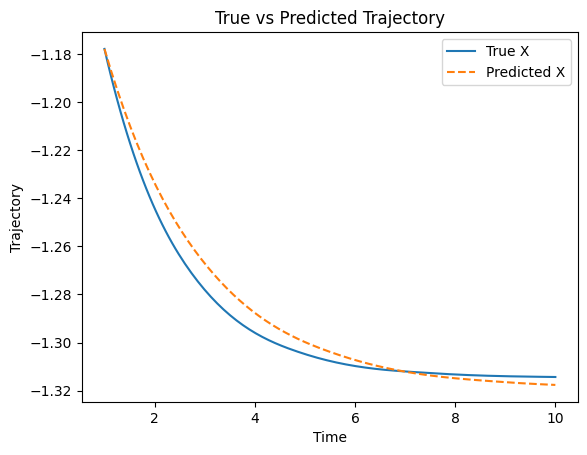

In [64]:
plt.plot(times, trajectory, label='True X')
plt.plot(times, pred_trajectory, label='Predicted X', linestyle='--')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Trajectory')
plt.title('True vs Predicted Trajectory')
plt.show()

### Testing 2d oscillating system

In [66]:
A = 0.25
B = 0.95

def diff_eq(t, z):
  x, y = z
  dxdt = - A * y
  dydt = B * x
  return [dxdt, dydt]

initial_conditions = [1,1]

max_t = 25
t_span = (0, max_t)
t_points = np.linspace(0, max_t, 1000)


solution = solve_ivp(diff_eq, t_span, initial_conditions, t_eval=t_points)

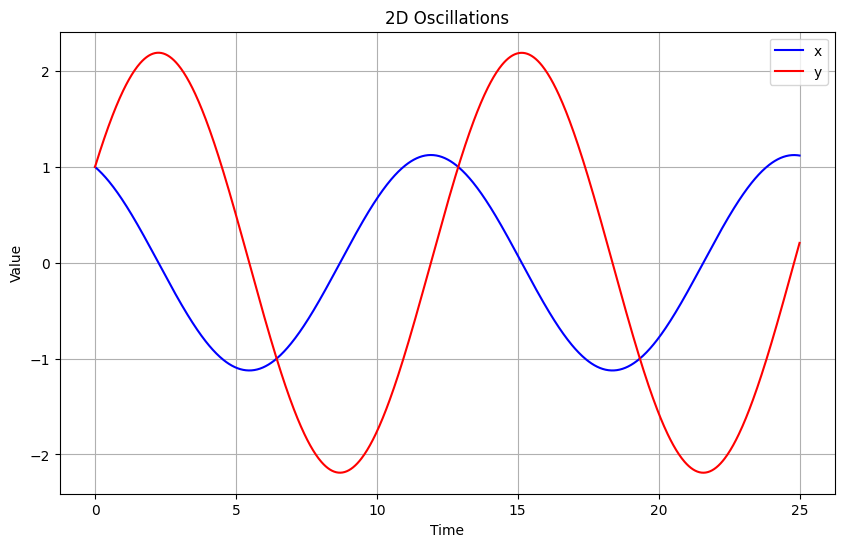

In [67]:
x = solution.y[0]
y = solution.y[1]
trajectory = np.stack([x, y], axis=1)

# plotting results
plt.figure(figsize=(10, 6))
plt.plot(t_points, x, label='x', color='blue')
plt.plot(t_points, y, label='y', color='red')
plt.title("2D Oscillations")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [68]:
candidates = dstr.fit(t_points, trajectory)

In [69]:
dstr.print(n_predictions=1)
pred_trajectory = dstr.predict(t_points, trajectory[0])
# evaluating prediction using R2 score
print("R2 Score:", r2_score(trajectory, pred_trajectory))

x_0' = -0.0464 * (-13.1000 + -1.0140 * x_1)**-1 + -0.2483 * x_1
x_1' = 0.9752 * x_0
R2 Score: 0.9960802480531945


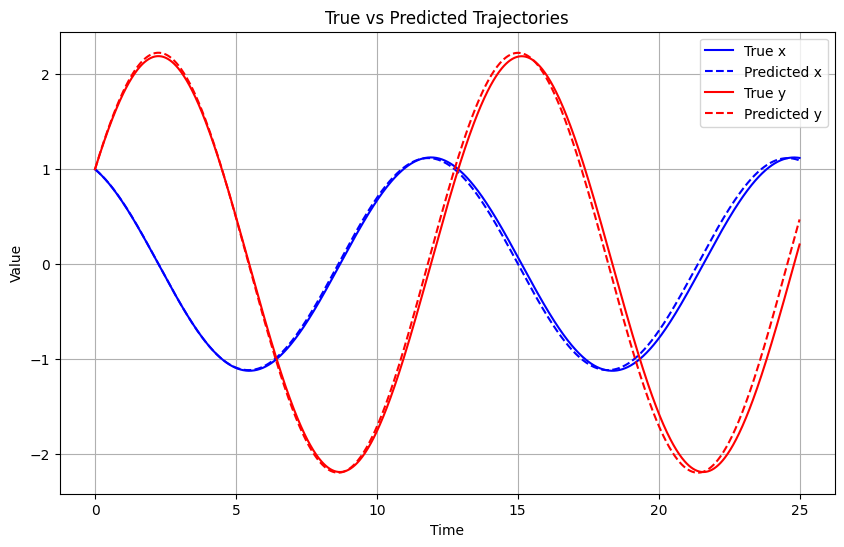

In [70]:
plt.figure(figsize=(10, 6))
plt.plot(t_points, trajectory[:, 0], label='True x', color='blue')
plt.plot(t_points, pred_trajectory[:, 0], label='Predicted x', linestyle='--', color='blue')
plt.plot(t_points, trajectory[:, 1], label='True y', color='red')
plt.plot(t_points, pred_trajectory[:, 1], label='Predicted y', linestyle='--', color='red')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('True vs Predicted Trajectories')
plt.grid(True)
plt.show()

### Testing hyperbolic growth

In [103]:
A = 0.25

def hyp_growth(t, x):
  dxdt = A * (x ** 2)
  return dxdt

initial_conditions = [1.0]

max_t = 10
t_span = (0, max_t)
t_points = np.linspace(0, max_t, 1000)


solution = solve_ivp(hyp_growth, t_span, initial_conditions, t_eval=t_points)
trajectory = solution.y[0]

In [104]:
candidates = dstr.fit(t_points, trajectory)

TypeError: 'numpy.float64' object does not support item assignment